In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Launching dataset
import os
os.chdir("/content/drive/My Drive/DS303_Dev")
Dataset = 'Dataset'
Data_dir = os.listdir(Dataset)
print(Data_dir)

['without_mask', 'with_mask']


In [5]:
!pwd

/content/drive/My Drive/DS303_Dev


In [6]:
#Checking sample data
# import PIL
# import PIL.Image

# image_path = "/content/drive/My Drive/DS project mask/Dataset/with_mask/0-with-mask.jpg"
# PIL.Image.open(str(image_path))

In [7]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [8]:
img_rows, img_cols = 112, 112

images = []
labels = []

for category in Data_dir:
  folder_path = os.path.join(Dataset, category)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img)
    img = cv2.imread(img_path)

    try:
      #Converting the image into gray scale 
      grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      #resizing grayscaled image into size 56x56 to keep images consistent
      resized_img = cv2.resize(grayscale_img,(img_rows, img_cols))
      images.append(resized_img)
      labels.append(category)
      
    except exception as e:
      print('Exception:', e)

images=np.array(images)/255.0
images=np.reshape(images,(images.shape[0],img_rows,img_cols,1))

#Perform one hot encoding on the labels since the labels are in textual form
lb = LabelBinarizer();
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

(train_x, test_X, train_y, test_y) = train_test_split(images, labels, test_size=0.25, random_state=0)

In [9]:
#import necessary Keras Libraries
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

#Define Model Parameters
num_classes=2
batch_size=32

#Build CNN model using sequential API
model=Sequential()

#First Layer group containing Convolution, Relu and MaxPooling Layers
model.add(Conv2D(64,(5,5),input_shape=(img_rows, img_cols, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second Layer group containing Convolution, Relu and MaxPooling Layers
model.add(Conv2D(128,(5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Third Layer group containing Convolution, Relu and MaxPooling Layers
model.add(Conv2D(256,(5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten and Dropout Layer to stack the output convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))

#Softmax Classifier
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 108, 108, 64)      1664      
_________________________________________________________________
activation (Activation)      (None, 108, 108, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       204928    
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       8

In [10]:
#Train the model
from keras.optimizers import Adam

epochs=50

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

fitted_model=model.fit(train_x,train_y,epochs=epochs,validation_split=0.25)

Epoch 1/50
25/25 [==============================] - 67s 3s/step - loss: 0.7342 - accuracy: 0.5285 - val_loss: 0.6435 - val_accuracy: 0.7946
Epoch 2/50
25/25 [==============================] - 65s 3s/step - loss: 0.6398 - accuracy: 0.6508 - val_loss: 0.4865 - val_accuracy: 0.7558
Epoch 3/50
25/25 [==============================] - 65s 3s/step - loss: 0.5056 - accuracy: 0.7611 - val_loss: 0.3454 - val_accuracy: 0.8721
Epoch 4/50
25/25 [==============================] - 65s 3s/step - loss: 0.3114 - accuracy: 0.8637 - val_loss: 0.2870 - val_accuracy: 0.8643
Epoch 5/50
25/25 [==============================] - 65s 3s/step - loss: 0.3163 - accuracy: 0.8643 - val_loss: 0.2196 - val_accuracy: 0.9109
Epoch 6/50
25/25 [==============================] - 65s 3s/step - loss: 0.1995 - accuracy: 0.9197 - val_loss: 0.2030 - val_accuracy: 0.9225
Epoch 7/50
25/25 [==============================] - 64s 3s/step - loss: 0.1791 - accuracy: 0.9358 - val_loss: 0.1563 - val_accuracy: 0.9225
Epoch 8/50
25/25 [==

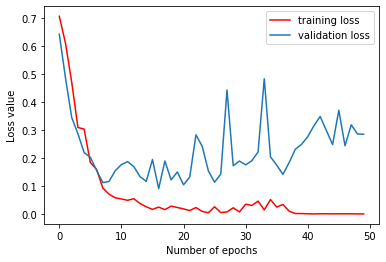

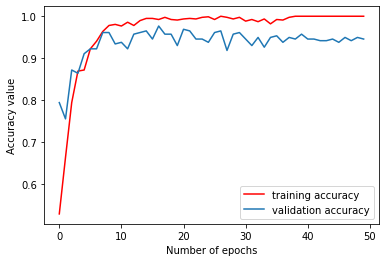

In [11]:
from matplotlib import pyplot as plt

#Plot Training and Validation Loss
plt.plot(fitted_model.history['loss'],'r',label='training loss')
plt.plot(fitted_model.history['val_loss'],label='validation loss')
plt.ylabel('Loss value')
plt.xlabel('Number of epochs')
plt.legend()
plt.show()

#Plot Training and Validation Loss
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='validation accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('Number of epochs')
plt.legend()
plt.show()

In [12]:
model.save('ds_project_SDD_256layer_5x5kernel.h5')